In [546]:
import pandas as pd
import numpy as np
import torch
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, Concatenate, Add, Masking, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MAE, MSE


In [516]:
X_encoder = torch.load('torch_data/X_encoder_ls.pt') # past features and target values
X_decoder = torch.load('torch_data/X_decoder_ls.pt') # future features values
y = torch.load('torch_data/y_ls.pt') # future target values

X_encoder.shape, X_decoder.shape, y.shape

((6044, 70, 5), (6044, 70, 4), (6044, 70, 1))

In [536]:
#split train test

from sklearn.model_selection import train_test_split

length = np.arange(0,X_encoder.shape[0],1)

train, test = train_test_split(length, test_size=0.20, random_state=42)

X_encoder_train = []
X_encoder_test = []
X_decoder_train = []
X_decoder_test = []

y_train = []
y_test = []

for i in train:
    X_encoder_train.append(X_encoder[i])
    X_decoder_train.append(X_decoder[i])
    y_train.append(y[i])
    
    
for i in test:
    X_encoder_test.append(X_encoder[i])
    X_decoder_test.append(X_decoder[i])
    y_test.append(y[i])
    
X_encoder_train = np.array(X_encoder_train)
X_encoder_test = np.array(X_encoder_test)
X_decoder_train = np.array(X_decoder_train)
X_decoder_test = np.array(X_decoder_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [553]:
# define the encoder and decoder
def encoder(encoder_features):
    y = Masking(mask_value = -1000.)(encoder_features)
    y = LSTM(units=100, return_sequences=True, activation='tanh')(y)
    y = GRU(units=10, return_sequences=True, activation='tanh')(y)
    y = TimeDistributed(Dense(units=1))(y)
    return y

def decoder(decoder_features, encoder_outputs):
    x = Concatenate(axis=-1)([decoder_features, encoder_outputs])
    # x = Add()([decoder_features, encoder_outputs]) 
    x = Masking(mask_value = -1000.)(x)
    y = TimeDistributed(Dense(units=100, activation='relu'))(x)
    y = TimeDistributed(Dense(units=1))(y)
    return y

In [554]:
# build the model
encoder_features = Input(shape=X_encoder.shape[1:])
decoder_features = Input(shape=X_decoder.shape[1:])
encoder_outputs = encoder(encoder_features)
decoder_outputs = decoder(decoder_features, encoder_outputs)
model = Model([encoder_features, decoder_features], decoder_outputs)

In [555]:
# train the model
metric = MAE

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse', metrics=[metric])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=2, restore_best_weights=True)

model.fit([X_encoder_train, X_decoder_train], y_train, epochs=100, batch_size=128, callbacks=[es], validation_split=0.3, verbose=1)

Epoch 1/100
27/27 [==============================] - 9s 150ms/step - loss: 587960.3750 - mean_absolute_error: 618.3553 - val_loss: 106526.0703 - val_mean_absolute_error: 278.9127
Epoch 2/100
27/27 [==============================] - 2s 90ms/step - loss: 26033.8691 - mean_absolute_error: 109.9567 - val_loss: 64.5224 - val_mean_absolute_error: 6.5209
Epoch 3/100
27/27 [==============================] - 2s 87ms/step - loss: 27.2576 - mean_absolute_error: 2.2061 - val_loss: 23.3640 - val_mean_absolute_error: 1.7269
Epoch 4/100
27/27 [==============================] - 2s 86ms/step - loss: 157.8210 - mean_absolute_error: 5.6428 - val_loss: 292.0699 - val_mean_absolute_error: 15.3725
Epoch 5/100
27/27 [==============================] - 2s 86ms/step - loss: 247.2072 - mean_absolute_error: 13.0898 - val_loss: 486.7478 - val_mean_absolute_error: 19.7615
Epoch 5: early stopping


In [556]:
model.evaluate([X_encoder_test, X_decoder_test], y_test)

38/38 [==============================] - 1s 15ms/step - loss: 22.8354 - mean_absolute_error: 1.7280


[22.83538246154785, 1.7279987335205078]

In [513]:
shuffled = np.arange(0,101,1)
np.random.shuffle(shuffled)
shuffled

array([ 95,  17,   2,  60,  28,  39,   0,  47,  52,   4,  26,  33,  58,
        67,  83,  63,  75,  88,  64,  71,  41,  84,  46,  44,  74,  59,
        65,  90,  53,   7,  80,  81,  15,  55,  89,  76,  77,  98,  22,
         1,  73,   5,  14,  78,  11,  43,  27,   3,  72,  86,  31,  61,
        16,  25,  85,  87,  19,  82,  48,  45,  35,  66,  50,  34,  10,
        62,  13,   6,  93,  79,  18,  40,  96,  92,  97,  30,  37,  57,
        51,  23, 100,  94,  42,  24,  56,  21,  32,  49,   9,  29,  36,
        20,  70,  99,  38,  91,  12,   8,  54,  68,  69])

In [373]:
X = torch.load('torch_data/X_full_scaled.pt')
y = torch.load('torch_data/y_full_scaled.pt')

In [374]:
X_tour = torch.load('torch_data/X_tour.pt')
y_tour = torch.load('torch_data/y_tour.pt')

In [418]:
X_tdf = torch.load('torch_data/X_tdf_2022.pt')
y_tdf = torch.load('torch_data/y_tdf_2022.pt')

X_tdf_tour = torch.load('torch_data/X_tour_tdf_2022.pt')
y_tdf_tour = torch.load('torch_data/y_tour_tdf_2022.pt')

In [417]:
y_tdf[0].shape

(62, 60)

In [428]:
X_tdf.shape, y_tdf.shape, X_tdf_tour.shape, y_tdf_tour.shape

((2210, 80, 4), (2210, 80, 1), (2210, 80, 4), (2210, 80, 1))

In [383]:
X_tour_pad = []
y_tour_pad = []

for xx in X_tour:
    X_tour_pad.append(pad_sequences(xx, maxlen=80, dtype='float', padding='pre', value=-1000.).T)
    
for yy in y_tour:
    y_tour_pad.append(pad_sequences(yy, maxlen=80, dtype='float', padding='pre', value=-1000.).T)
    
X_tour_pad = np.array(X_tour_pad)
y_tour_pad = np.array(y_tour_pad)

In [384]:
X_tour_pad.shape, y_tour_pad.shape

((38304, 80, 4), (38304, 80, 1))

In [385]:
X.shape, y.shape

((38304, 80, 4), (38304, 21, 1))

In [378]:
train_data_merged = []

for xx, yy in zip(X, y):
    train_data_merged.append(np.concatenate((xx, yy), axis=1))
    
train_data_merged = np.array(train_data_merged)

train_data_merged.shape

(38304, 80, 5)

In [429]:
train_data_merged_pred = []

for xx, yy in zip(X_tdf, y_tdf):
    train_data_merged_pred.append(np.concatenate((xx, yy), axis=1))
    
train_data_merged_pred = np.array(train_data_merged_pred)

train_data_merged_pred.shape

(2210, 80, 5)

In [358]:
# train the model
from tensorflow.keras.callbacks import EarlyStopping
metric = metrics.MAE

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[metric])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=2, restore_best_weights=True)

model.fit([X_encoder, X_decoder], y, epochs=100, batch_size=128, callbacks=[es], validation_split=0.3, verbose=1)

In [426]:
X_encoder = train_data_merged  # past features and target values
X_decoder = X_tour_pad  # future features values
y = y_tour_pad          # future target values

X_encoder.shape, X_decoder.shape, y.shape

((38304, 80, 5), (38304, 80, 4), (38304, 80, 1))

In [430]:
X_encoder_pred = train_data_merged_pred  # past features and target values
X_decoder_pred = X_tdf_tour  # future features values
y_pred = y_tdf_tour

X_encoder_pred.shape, X_decoder_pred.shape, y_pred.shape

((2210, 80, 5), (2210, 80, 4), (2210, 80, 1))

In [459]:
X_tdf_tour[0][-21:]

array([[-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [-1.00000000e+03, -1.00000000e+03, -1.00000000e+03,
        -1.00000000e+03],
       [ 4.01315789e-02,  3.79506641e-03,  3.02637268e-03,
         8.55408389e-01],
       [ 6.61842105e-01,  0.00000000e+00,  1.65585819e-01,
         8.55408389e-01],
       [ 5.95394737e-01,  9.48766603e-03,  1.84464620e-01,
         8.55408389e-01],
       [ 5.60855263e-01,  9.86717268e-02,  2.57241677e-01,
      

In [387]:
# define the encoder and decoder
def encoder(encoder_features):
    y = Masking(mask_value = -1000.)(encoder_features)
    y = LSTM(units=100, return_sequences=True)(y)
    y = TimeDistributed(Dense(units=1))(y)
    return y

def decoder(decoder_features, encoder_outputs):
    x = Concatenate(axis=-1)([decoder_features, encoder_outputs])
    # x = Add()([decoder_features, encoder_outputs]) 
    x = Masking(mask_value = -1000.)(x)
    y = TimeDistributed(Dense(units=100, activation='relu'))(x)
    y = TimeDistributed(Dense(units=1))(y)
    return y

In [389]:
# build the model
encoder_features = Input(shape=X_encoder.shape[1:])
decoder_features = Input(shape=X_decoder.shape[1:])
encoder_outputs = encoder(encoder_features)
decoder_outputs = decoder(decoder_features, encoder_outputs)
model = Model([encoder_features, decoder_features], decoder_outputs)

In [394]:
# train the model
from tensorflow.keras.callbacks import EarlyStopping
metric = metrics.MAE

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=[metric])

es = EarlyStopping(monitor='val_loss', verbose=1, patience=2, restore_best_weights=True)

model.fit([X_encoder, X_decoder], y, epochs=100, batch_size=128, callbacks=[es], validation_split=0.3, verbose=1)

Epoch 1/100
210/210 [==============================] - 19s 77ms/step - loss: 44.6760 - mean_absolute_error: 3.1075 - val_loss: 23.3128 - val_mean_absolute_error: 1.7873
Epoch 2/100
210/210 [==============================] - 15s 73ms/step - loss: 18.5712 - mean_absolute_error: 1.4276 - val_loss: 19.5045 - val_mean_absolute_error: 1.3631
Epoch 3/100
210/210 [==============================] - 15s 73ms/step - loss: 17.1064 - mean_absolute_error: 1.3262 - val_loss: 18.8654 - val_mean_absolute_error: 1.6384
Epoch 4/100
210/210 [==============================] - 15s 73ms/step - loss: 16.4553 - mean_absolute_error: 1.3535 - val_loss: 18.1419 - val_mean_absolute_error: 1.3189
Epoch 5/100
210/210 [==============================] - 15s 73ms/step - loss: 15.9128 - mean_absolute_error: 1.3751 - val_loss: 17.7999 - val_mean_absolute_error: 1.3541
Epoch 6/100
210/210 [==============================] - 15s 73ms/step - loss: 18.0648 - mean_absolute_error: 1.7998 - val_loss: 22.1699 - val_mean_absolute_

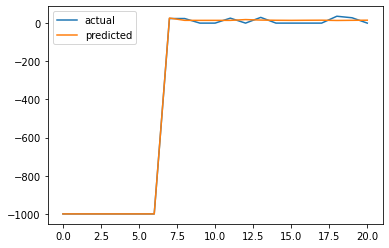

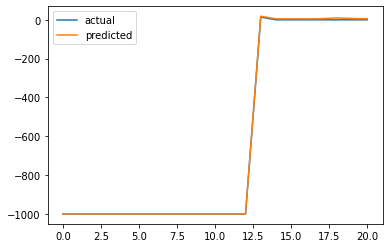

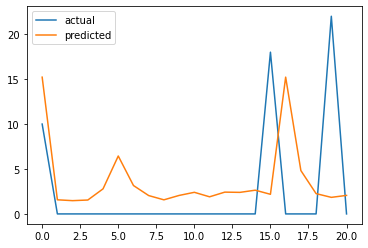

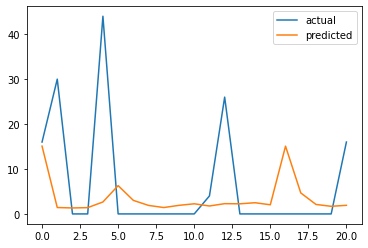

In [408]:
# extract the last predicted sequence
for seq in [-24, -36, -87, -103]:

    y_true = y[seq, :][-21:]
    y_pred = model.predict([X_encoder, X_decoder])[seq, :][-21:]

    # plot the last predicted sequence
    plt.plot(y_true.flatten(), label='actual')
    plt.plot(y_pred.flatten(), label='predicted')
    plt.legend()
    plt.show()

In [431]:
y_pred = model.predict([X_encoder_pred, X_decoder_pred])

In [498]:
y_pred[141][-21:]

array([[-999.9335   ],
       [-999.9538   ],
       [-999.9408   ],
       [-999.95404  ],
       [-999.95416  ],
       [-999.9541   ],
       [-999.9541   ],
       [-999.9541   ],
       [  -2.3633783],
       [  -2.4015312],
       [  -2.40442  ],
       [  -2.4071722],
       [  -2.3799295],
       [  -2.4229388],
       [  -2.3871193],
       [  -2.424222 ],
       [  -2.4134839],
       [  -2.41201  ],
       [  -2.3719888],
       [  -2.3917294],
       [  -2.4107258]], dtype=float32)

In [403]:
y[-1, :][-22:]

array([[-1000.],
       [   18.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.]])

In [205]:
X2 = []
y2 = []

for xx, yy in zip(X,y):
    X2.append(xx.T)
    y2.append(yy.T)
    
X2 = np.array(X2)
y2 = np.array(y2)

print(X2.shape)
print(y2.shape)

(36268, 60, 4)
(36268, 60, 1)


In [206]:
X_train, X_test = X2[:29014], X2[29014:]
y_train, y_test = y2[:29014], y2[29014:]

In [207]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [216]:
def init_model():
    metric = metrics.MAE
    opt = optimizers.RMSprop(learning_rate=0.01)
    
    #normalizer = Normalization()
    #normalizer.adapt(X_train)
    
    model = models.Sequential()
    model.add(layers.Masking(mask_value=-1000., input_shape=(60,4)))
    #model.add(normalizer)
    model.add(layers.LSTM(20, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(10, return_sequences=True, activation='tanh'))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))
    
    model.compile(loss='mse',
                  optimizer=opt,
                  metrics = [metric])
    
    return model

In [217]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_26 (Masking)        (None, 60, 4)             0         
                                                                 
 normalization_22 (Normaliza  (None, 60, 4)            9         
 tion)                                                           
                                                                 
 lstm_45 (LSTM)              (None, 60, 20)            2000      
                                                                 
 lstm_46 (LSTM)              (None, 60, 10)            1240      
                                                                 
 dense_55 (Dense)            (None, 60, 50)            550       
                                                                 
 dense_56 (Dense)            (None, 60, 10)            510       
                                                     

In [218]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', verbose=1, patience=2, restore_best_weights=True)

model = init_model()

history = model.fit(X_train, y_train, epochs=3, validation_split=0.2, 
            batch_size=64,
            callbacks=[es], verbose=2)

Epoch 1/3
363/363 - 12s - loss: 24119.9844 - mean_absolute_error: 45.2602 - val_loss: 162.1123 - val_mean_absolute_error: 9.7059 - 12s/epoch - 34ms/step
Epoch 2/3
363/363 - 9s - loss: 1105.1848 - mean_absolute_error: 11.4878 - val_loss: 181.4655 - val_mean_absolute_error: 11.2093 - 9s/epoch - 24ms/step
Epoch 3/3
Restoring model weights from the end of the best epoch: 1.
363/363 - 9s - loss: 1166.8269 - mean_absolute_error: 10.8595 - val_loss: 434.6733 - val_mean_absolute_error: 16.4256 - 9s/epoch - 24ms/step
Epoch 3: early stopping


In [219]:
model.evaluate(X_test, y_test)

227/227 [==============================] - 1s 6ms/step - loss: 172.1444 - mean_absolute_error: 10.3812


[172.14443969726562, 10.381194114685059]

In [220]:
prediction = model.predict(X_test)

In [224]:
y_test[0]

array([[    2.],
       [   24.],
       [   16.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [   24.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [   20.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [    0.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.],
       [-1000.

In [223]:
prediction[0]

array([[   1.637166 ],
       [   2.5607803],
       [   2.8002381],
       [   2.861462 ],
       [   2.9029677],
       [   2.926814 ],
       [   2.9526014],
       [   3.0281916],
       [   3.0470035],
       [   3.1738315],
       [   3.2406805],
       [   3.163703 ],
       [   3.122875 ],
       [   3.1297417],
       [   3.0497375],
       [   3.0244846],
       [   3.014164 ],
       [   3.0789998],
       [   3.0488122],
       [   3.0417457],
       [   3.0359643],
       [   3.3961957],
       [   3.5793905],
       [   3.276527 ],
       [   3.377349 ],
       [   3.4301891],
       [   3.6137505],
       [   3.259481 ],
       [-959.6419   ],
       [-986.57965  ],
       [-986.2376   ],
       [-983.0091   ],
       [-982.3925   ],
       [-984.5135   ],
       [-985.385    ],
       [-985.9052   ],
       [-986.1657   ],
       [-986.3189   ],
       [-986.419    ],
       [-986.4943   ],
       [-986.5567   ],
       [-986.6114   ],
       [-986.6608   ],
       [-98

In [49]:
history.history

{'loss': [34356968.0,
  24494996.0,
  16713496.0,
  15075442.0,
  15033100.0,
  15030301.0,
  15029687.0,
  15029394.0,
  15029253.0,
  15029116.0,
  15029027.0,
  15028953.0,
  15028918.0,
  15028885.0,
  15028829.0,
  15028805.0,
  15028790.0],
 'mean_squared_error': [34356968.0,
  24494996.0,
  16713496.0,
  15075442.0,
  15033100.0,
  15030301.0,
  15029687.0,
  15029394.0,
  15029253.0,
  15029116.0,
  15029027.0,
  15028953.0,
  15028918.0,
  15028885.0,
  15028829.0,
  15028805.0,
  15028790.0],
 'val_loss': [45338640.0,
  26658382.0,
  17907072.0,
  17456198.0,
  17448940.0,
  17440516.0,
  17439674.0,
  17450650.0,
  17441042.0,
  17441914.0,
  17440762.0,
  17439960.0,
  17440532.0,
  17440828.0,
  17439944.0,
  17439718.0,
  17440314.0],
 'val_mean_squared_error': [45338640.0,
  26658382.0,
  17907072.0,
  17456198.0,
  17448940.0,
  17440516.0,
  17439674.0,
  17450650.0,
  17441042.0,
  17441914.0,
  17440762.0,
  17439960.0,
  17440532.0,
  17440828.0,
  17439944.0,
  174

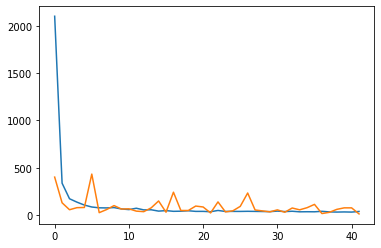

In [169]:
import matplotlib.pyplot as plt
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

In [51]:
df = pd.read_csv('merged_treated.csv', index_col=[0])
df.head()

,name,year,type,date,result,gc,icon,race_ref,race_name,race_detail,...,distance,points,Avg. speed winner:,Distance:,Parcours type:,ProfileScore:,Vert. meters:,Startlist quality score:,Won how:,adjusted_points
0,egan-bernal,2020,etappe,2020-09-16,0,NaN,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,170.0,0.0,35.28,170.0,mo_mo,444.0,4430.0,1685,3.5 km solo,0.0
1,andrey-amador,2020,etappe,2020-09-16,117,79.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,170.0,0.0,35.28,170.0,mo_mo,444.0,4430.0,1685,3.5 km solo,0.0
2,richard-carapaz,2020,etappe,2020-09-16,11,13.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,170.0,20.0,35.28,170.0,mo_mo,444.0,4430.0,1685,3.5 km solo,14962800.0
3,jonathan-castroviejo,2020,etappe,2020-09-16,116,40.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,170.0,0.0,35.28,170.0,mo_mo,444.0,4430.0,1685,3.5 km solo,0.0
4,michal-kwiatkowski,2020,etappe,2020-09-16,130,37.0,stage,race/tour-de-france/2020/stage-17,tour-de-france,Stage 17 - Grenoble › Méribel - Col de la Loze,...,170.0,0.0,35.28,170.0,mo_mo,444.0,4430.0,1685,3.5 km solo,0.0


In [56]:
for i in df.name.unique()[:2]:
    print(i)

egan-bernal
andrey-amador


In [57]:
ls = []

for rider in df.name.unique()[:2]:
    ls.append(df_small[df_small['name']==rider])

In [ ]:
import numpy as np

def subsample_sequence(df, length):
        df_small[df_small['name']==rider]
        # $CHALLENGIFY_BEGIN
        last_possible = df.shape[0] - length - 5
        
        random_start = np.random.randint(0, last_possible)
        X = df[random_start: random_start+length].values
        y = df.iloc[random_start+length+1:random_start+length+21]['points']
        # $CHALLENGIFY_END
        return X, y

for rider in ls:
    X, y = subsample_sequence(rider, 365)

/var/folders/3l/70h6qcrd72q0j5x4sscw7qn40000gn/T/ipykernel_9756/69888416.py:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df_small[df_small['name']==rider]


: 

: 

In [ ]:
X

array([[13.8, 0.0, 13.0, 28.0, 1812, 'daniele-bennati'],
       [13.8, 0.0, 13.0, 28.0, 1812, 'roman-kreuziger'],
       [13.8, 0.0, 13.0, 28.0, 1812, 'rafal-majka'],
       ...,
       [155.0, 0.0, 323.0, 4282.0, 1073, 'marcel-wyss'],
       [155.0, 0.0, 323.0, 4282.0, 1073, 'dominik-nerz'],
       [155.0, 0.0, 323.0, 4282.0, 1073, 'jan-barta']], dtype=object)